<a href="https://colab.research.google.com/github/ahmedlila/Machine-Learning-Course-Implementations/blob/main/Lab%2010%20-%20SVM%20and%20Naive%20Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://zewailcity.edu.eg/main/images/logo3.png) 

_Requirements Solved by_  [**Ahmed Lila - 201800251**](mailto:s-ahmedlila@zewailcity.edu.eg) 


# Task 1  
[10 Points]: Work with [Amazon Fine Food Reviews dataset](https://www.kaggle.com/snap/amazon-fine-food-reviews)
    - Perform proper preprocessing and visualization
    - Perform proper hyperparameter tuning **-SVM-**. JUSTIFY ALL THE HYPERPARAMETER VALUES
    - **Hint**: Check [this](https://towardsdatascience.com/support-vector-machines-svm-c9ef22815589) tutorial and this [kernel](https://www.kaggle.com/laowingkin/amazon-fine-food-review-sentiment-analysis) for help 

## About the Dataset

**Attributes:**

- Id
- ProductId - unique identifier for the product
- UserId - unqiue identifier for the user
- ProfileName
- HelpfulnessNumerator - number of users who found the review helpful
- HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
- Score - rating between 1 and 5
- Time - timestamp for the review
- Summary - brief summary of the review
- Text - text of the review

## A- Exploratory Data Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/Github/Task 10

/content/drive/My Drive/Github/Task 10


In [3]:
ls

Reviews.csv


In [202]:
!pip install nltk

In [218]:
#import needed libraries 
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
import sklearn.preprocessing
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, MultiTaskLassoCV, LassoLarsCV, LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, LeaveOneOut
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, mean_squared_error, r2_score, roc_auc_score, mean_absolute_error, roc_curve

from sklearn.feature_selection import RFE
import lightgbm
from lightgbm import LGBMClassifier
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.svm import SVC, LinearSVC
import nltk
from wordcloud import WordCloud, STOPWORDS

In [5]:
df=pd.read_csv('./Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


### Preprocessing

In [8]:
df = df[df['Score'] != 3] #Drop Neutral
df['Score']= df['Score'].map({1:0, 2:0, 4:1, 5:1}) #+ve and -ve classes

In [9]:
df['Score'].value_counts().to_frame()

,Score
1,443777
0,82037


### Missing data and Duplicates 

In [10]:
#Train Invoice: Checking Nulls and Duplicates
print('Data : missing values -> {}'.format(df.isna().sum().sum()))
print('Data: duplicate values -> {}'.format(df.duplicated().sum()))
print('Data: Shape -> {}'.format(df.shape))

Data : missing values -> 41
Data: duplicate values -> 0
Data: Shape -> (525814, 10)


In [11]:
# Remove Any duplicates or Missing values: Reduce redundancy
#CODE
df.dropna(inplace=True)
df.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=True)
#TEST
print('Data : missing values -> {}'.format(df.isna().sum().sum()))
print('Data: duplicate values -> {}'.format(df.duplicated().sum()))
print('Data: Shape -> {}'.format(df.shape))

Data : missing values -> 0
Data: duplicate values -> 0
Data: Shape -> (364161, 10)


In [61]:
#Denominator Should be higher than nominator
df=df[df.HelpfulnessNumerator<=df.HelpfulnessDenominator]
#Helpfulness feature: ratio between Numerator and Denominator
df['Helpfulness']=df.HelpfulnessNumerator/df.HelpfulnessDenominator
df['Helpfulness']= df['Helpfulness'].fillna(0.5)
df

(364159, 11)

### Univariate Analysis

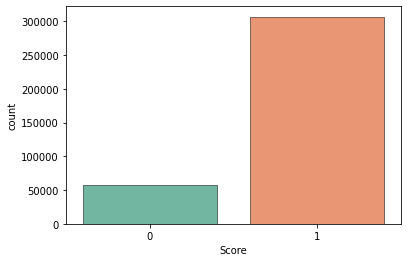

In [14]:
sns.countplot(x='Score',data=df, palette='Set2', linewidth=0.5, edgecolor='black');

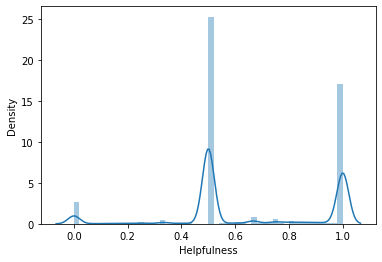

In [63]:
sns.distplot(df['Helpfulness']);

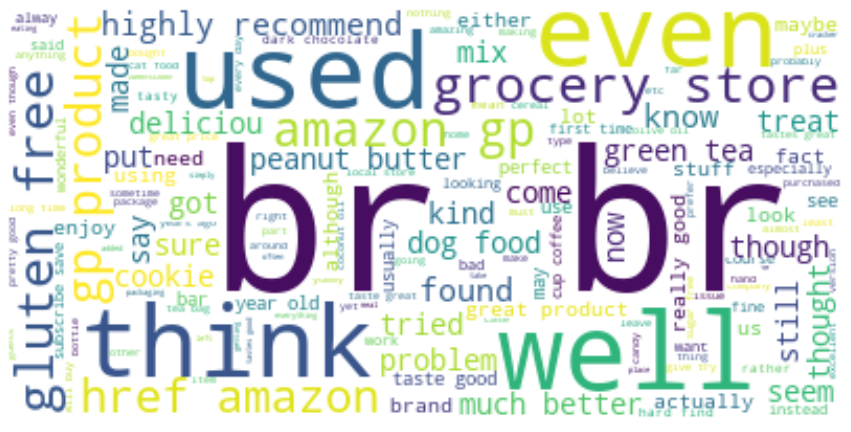

In [217]:
#Generate Wordcloud
text = " ".join(str(i) for i in df.Text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## B- Sentiment Analysis using TF-IDF Vectorizer

In [98]:
X=df['Text']
y= df['Score']

In [99]:
tfidf_vectoriser = TfidfVectorizer()
tfidf_vectoriser.fit(X)
X_tf = tfidf_vectoriser.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_tf, y, test_size = 0.2, random_state = 101, shuffle=True)

In [100]:
print("Shape Of Training Set",X_train.shape)
print("Shape Of Testing Set",X_test.shape)
print("Shape Of Training Target",y_train.shape)
print("Shape Of Testing Target",y_test.shape)

Shape Of Training Set (291327, 115279)
Shape Of Testing Set (72832, 115279)
Shape Of Training Target (291327,)
Shape Of Testing Target (72832,)


## C- Models

### 1) Logistic Regression 

In [101]:
log_reg = LogisticRegression().fit(X_train, y_train)

# Predict the labels 
y_predict = log_reg.predict(X_test)

# Print the performance metrics
print('Accuracy score of test data: ', accuracy_score(y_test, y_predict))
print('Confusion matrix of test data: \n', confusion_matrix(y_test, y_predict)/len(y_test))

Accuracy score of test data:  0.9310330623901582
Confusion matrix of test data: 
 [[0.10765872 0.05011533]
 [0.0188516  0.82337434]]


### 2) SVC

Used the LinearSVC instead of instead of SVC with StandardScaler as it's less complex, Lower SVC 

In [40]:
param_grid = {
    'C': [x for x in np.linspace(start = 0.01, stop = 1, num = 5)]
}

svc_grid = GridSearchCV(LinearSVC(), param_grid= param_grid, cv=5)
%time svc_grid.fit(X_train, y_train)

CPU times: user 1min 50s, sys: 336 ms, total: 1min 51s
Wall time: 1min 51s


GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.01, 0.2575, 0.505, 0.7525, 1.0]})

In [41]:
svc_grid.best_params_, svc_grid.best_score_

({'C': 0.505}, 0.933133548510446)

In [44]:
# Predict the labels 
y_predict = svc_grid.predict(X_test)
svc_clf= LinearSVC(**svc_grid.best_params_) #Best Parameters
svc_clf.fit(X_train, y_train)
accuracy_score(y_test, y_predict)

0.9338340289982425

C is small to regularize the model.

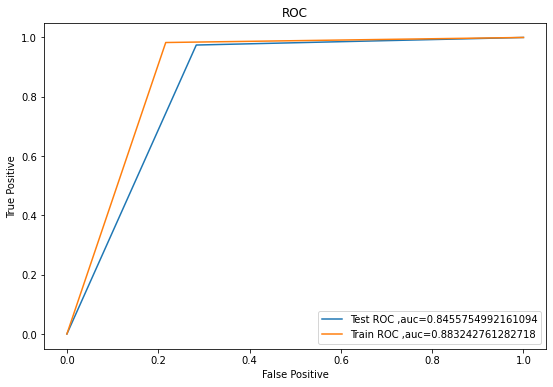

In [68]:
#ROC curve
svm=LinearSVC(**svc_grid.best_params_)
svm.fit(X_train,y_train)
predi=svm.predict(X_test)
fpr1, tpr1, thresholds1 = roc_curve(y_test, predi)
pred=svm.predict(X_train)
fpr2,tpr2,thresholds2=roc_curve(y_train,pred)
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
ax.legend()
plt.show()

## ============================================================================

# Task 2 (Bouns)
 [3 Points] : Follow [this tutorial](https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn) on **Naive Bayes** and apply what you learnt on the [Spam Classification dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset)



## About the Dataset

The files contain one message per line. Each line is composed by two columns: 
- v1 (target) contains the label (ham or spam)
- v2(Text) contains the raw text.

## Exploratory Data Analysis

### 1) Data Preprocessing

In [209]:
ls

Reviews.csv  spam.csv  spam.xlsx


In [210]:
data=pd.read_excel('./spam.xlsx')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [211]:
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
data.rename({'v1': 'target', 'v2': 'Text'}, axis=1, inplace=True)
data

,target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [212]:
data['target']= data['target'].map({'spam':1, 'ham':0})
data

,target,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


### 2) Univariate Analysis

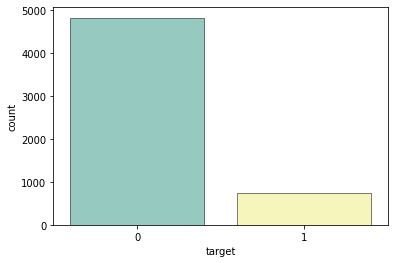

In [213]:
sns.countplot(x='target',data=data, palette='Set3', linewidth=0.5, edgecolor='black');

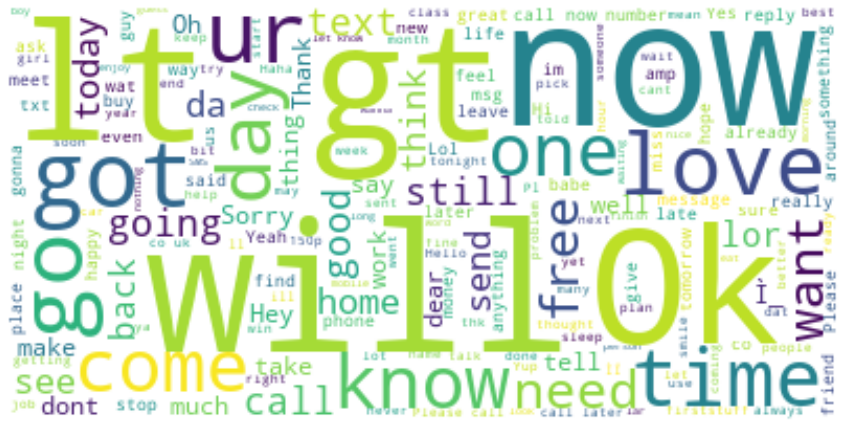

In [216]:
#Generate Wordcloud
text = " ".join(str(i) for i in data.Text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## B- Sentiment Analysis using TF-IDF Vectorizer

In [177]:
X=data['Text']
y= data['target']

In [178]:
X = [str(item) for item in X]
X= pd.Series(X)
X.shape

(5572,)

In [179]:
tfidf_vectoriser = TfidfVectorizer()
tfidf_vectoriser.fit(X)
X_tf = tfidf_vectoriser.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_tf, y, test_size = 0.2, random_state = 101, shuffle=True)

In [180]:
print("Shape Of Training Set",X_train.shape)
print("Shape Of Testing Set",X_test.shape)
print("Shape Of Training Target",y_train.shape)
print("Shape Of Testing Target",y_test.shape)

Shape Of Training Set (4457, 8673)
Shape Of Testing Set (1115, 8673)
Shape Of Training Target (4457,)
Shape Of Testing Target (1115,)


In [183]:
from sklearn.naive_bayes import GaussianNB
#Create a Gaussian Classifier
NB = GaussianNB()
# Train the model using the training sets
NB.fit(X_train.toarray(), y_train)

#Predict Output
predicted= NB.predict(X_test.toarray()) # 0:Overcast, 2:Mild
# Print the performance metrics
print('Accuracy score of test data: ', accuracy_score(y_test, predicted))
print('Confusion matrix of test data: \n', confusion_matrix(y_test, predicted)/len(y_test))

Accuracy score of test data:  0.8896860986547085
Confusion matrix of test data: 
 [[0.7793722  0.09686099]
 [0.01345291 0.1103139 ]]
